In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from PIL import Image
from tqdm import tqdm_notebook as tqdm
import time
import torch
import torch.nn.parallel
import torch.nn as nn
import torch.utils.data
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F

import my_log
from models.utils import *
from my_fn import *
model = load_model('shufflenetv2plus_x1.0')

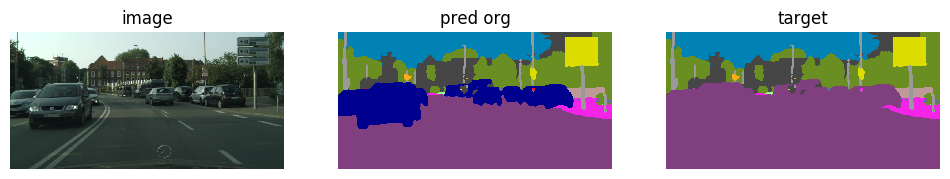

In [3]:
mean = [0.2997, 0.3402, 0.3072]; std = [0.1549, 0.1579, 0.1552]
# mean = [0, 0, 0]; std = [1, 1, 1]
# net_h, net_w = 1024, 2048
net_h, net_w = 512, 1024

# img = Image.open("deploy/cityscapes/examples/aachen_000014_000019_gtFine_labelIds_synthesized_image.png")
# img = Image.open("deploy/cityscapes/examples/frankfurt_000000_014480_leftImg8bit.png")
# img = Image.open("deploy/cityscapes/examples/lindau_000013_000019_leftImg8bit.png")
img = Image.open("deploy/cityscapes/examples/munster_000168_000019_leftImg8bit.png")
# img = Image.open("deploy/kitti/examples/kitti_01.png")

img = img.resize((net_w, net_h),Image.BILINEAR)
# transform = T.Compose([T.Resize((net_h, net_w)),T.ToTensor(), T.Normalize(mean=mean,std=std)])
transform = T.Compose([T.Resize((net_h, net_w)),T.ToTensor()])

image = transform(img).to('cuda').unsqueeze(0)
image.requires_grad = False
w = torch.zeros_like(image, requires_grad=True).cuda()
opt = optim.Adam([w], lr=0.01, betas=(0.9, 0.999))

with torch.no_grad():
    image_input = Normalize_Batch(image,mean,std,inplace=False)
    pred = model(image_input).squeeze(0).max(0)[1]
    pred_org = pred.cpu().numpy().astype(np.int64)
    del pred,image_input

pred_target = pred_org.copy()
pred_target = np.where(pred_target == class_names.index('car'), class_names.index('road'), pred_target)
pred_target = np.where(pred_target == class_names.index('person'), class_names.index('sidewalk'), pred_target)
pred_target = np.where(pred_target == class_names.index('rider'), class_names.index('sidewalk'), pred_target)
pred_target = np.where(pred_target == class_names.index('bicycle'), class_names.index('road'), pred_target)
target = torch.from_numpy(pred_target).unsqueeze(0).cuda()

fig = plt.figure(figsize=(12, 6), dpi=100, facecolor='w', edgecolor='k')
sub_plot(fig,1,3,1,'image',img)
sub_plot(fig,1,3,2,'pred org',label_colors[pred_org])
sub_plot(fig,1,3,3,'target',label_colors[pred_target])
plt.show()

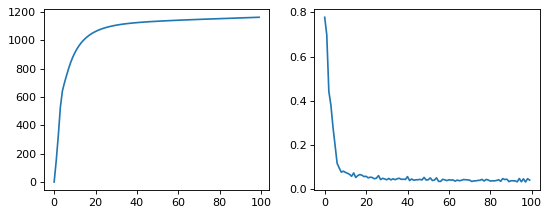

In [4]:
eps = 0.03
epoches = 100
buf = []
for i in tqdm(range(epoches)):
    w_clip = torch.clamp(w, -eps, eps)
    adv_input = torch.clamp(w_clip + image,0,1)
    Normalize_Batch(adv_input,mean,std,inplace=True)
    logits = model(adv_input)
    loss_l2 = (w_clip**2).sum()
    loss_cross = nn.CrossEntropyLoss()(logits, target)
    
    loss = loss_cross
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    buf.append([num(loss_l2), num(loss_cross)])
    torch.cuda.empty_cache()
buf = np.array(buf)

fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(1,2,1);plt.plot(buf[:,0])
plt.subplot(1,2,2);plt.plot(buf[:,1])
plt.show()

(512, 1024, 3) min: 0.03137255 max: 1.0 sum: 507.7504 mean: 0.4048598 
(512, 1024, 3) min: -0.03 max: 0.03 sum: 34.099846 mean: 0.02718985 


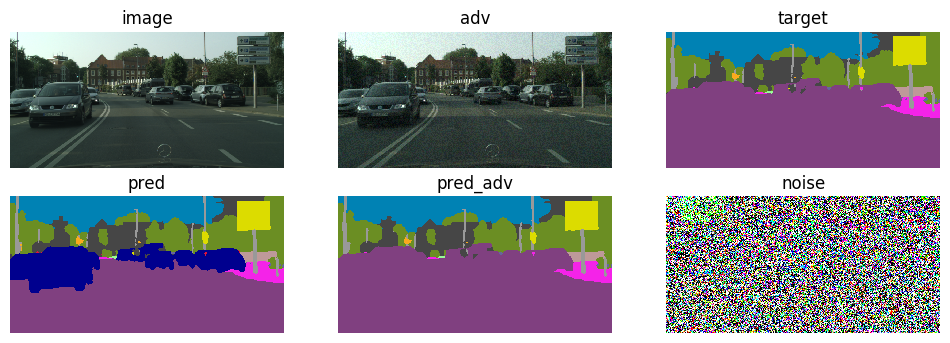

In [5]:
with torch.no_grad():
    image_input = Normalize_Batch(image,mean,std,inplace = False)
    logits = model(image_input)
    pred = num(logits.squeeze(0).max(0)[1])
    
    adv_input = torch.clamp(image + w_clip,0,1)
    image_input = Normalize_Batch(adv_input,mean,std,inplace = False)
    logits = model(image_input)
    pred_adv = num(logits.squeeze(0).max(0)[1])

img_org = num(image[0]).transpose((1,2,0))
img_adv = num(adv_input[0]).transpose((1,2,0))

noise_np = num(w_clip[0]).transpose((1,2,0))
print_l2(img_org)
print_l2(noise_np)

fig = plt.figure(figsize=(12, 4), dpi=100, facecolor='w', edgecolor='k')
sub_plot(fig,2,3,1,'image',img_org)
sub_plot(fig,2,3,2,'adv',img_adv)
sub_plot(fig,2,3,3,'target',label_colors[pred_target])
sub_plot(fig,2,3,4,'pred',label_colors[pred])
sub_plot(fig,2,3,5,'pred_adv',label_colors[pred_adv])
sub_plot(fig,2,3,6,'noise',norm_01(noise_np))
plt.show()

(512, 1024, 3) float32 min: 0.03137255 max: 1.0 
(512, 1024, 3) min: -0.03 max: 0.03 sum: 34.099846 mean: 0.02718985 
(512, 1024, 3) float32 min: 0.00529412 max: 1.0 


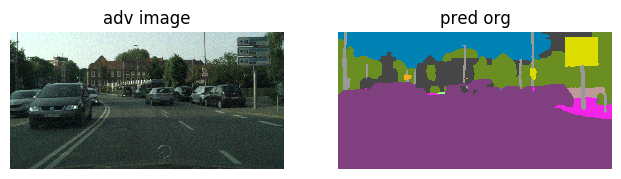

In [6]:
img_org = num(image[0]).transpose((1,2,0))
noise = num(w_clip[0]).transpose((1,2,0))
adv_img = np.clip(noise + img_org, 0, 1)

print_mat(img_org)
print_l2(noise)
print_mat(adv_img)

pil_image = Image.fromarray((adv_img*255).astype(np.uint8))
img.save('tmp/org.png')
pil_image.save('tmp/tmp.png')

pil_reload = Image.open("tmp/tmp.png")
image_input = transform(pil_reload).to('cuda').unsqueeze(0)
logits = model(image_input)
pred = num(logits.squeeze(0).max(0)[1])

fig = plt.figure(figsize=(12, 4), dpi=100, facecolor='w', edgecolor='k')
sub_plot(fig,1,3,1,'adv image',pil_reload)
sub_plot(fig,1,3,2,'pred org',label_colors[pred])
plt.show()